In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### EEZ shapes 

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

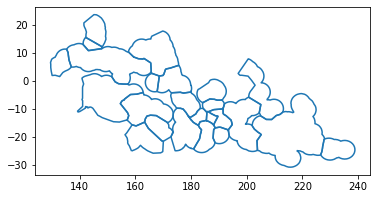

In [9]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [10]:
date = 'this month'

In [11]:
year = dateparser.parse(date).year

In [12]:
month = dateparser.parse(date).month

In [13]:
print(f"{year} - {month}")

2021 - 10


### read the probabilistic forecasts from the GCMs now 

### provider 

In [14]:
provider = 'CDS'

#### list of GCMs to inlude 

In [15]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC']

#### period (`monthly` or `seasonal`)

In [16]:
period = 'monthly'
# period = 'seasonal'

In [17]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [18]:
quantile = 'tercile'

### variable 

In [19]:
varname = 'precip'

### domain 

In [20]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [120, 240, -38, 22.5]}

In [21]:
domain = 'Water_Watch'

### paths to the realtime forecasts

In [22]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [23]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [24]:
[f.name for f in lfiles]

['monthly_terciles_probabilities_from_2021-10_UKMO.netcdf',
 'monthly_terciles_probabilities_from_2021-10_NCEP.netcdf',
 'monthly_terciles_probabilities_from_2021-10_JMA.netcdf',
 'monthly_terciles_probabilities_from_2021-10_CMCC.netcdf',
 'monthly_terciles_probabilities_from_2021-10_ECMWF.netcdf',
 'monthly_terciles_probabilities_from_2021-10_ECCC.netcdf',
 'monthly_terciles_probabilities_from_2021-10_DWD.netcdf',
 'monthly_terciles_probabilities_from_2021-10_METEO_FRANCE.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [25]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', engine='netcdf4') 

### interpolate

In [26]:
probs = utils.interp(probs)

In [27]:
probs = probs.mean('GCM')

In [28]:
probs

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 5, lat: 324, lon: 484)
Coordinates:
  * time     (time) datetime64[ns] 2021-10-01
  * step     (step) int64 1 2 3 4 5
    month    int64 10
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.5 120.7 ... 239.3 239.5 239.8 240.0
  * lat      (lat) float64 -50.0 -49.75 -49.5 -49.26 ... 29.26 29.5 29.75 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 324, 484), meta=np.ndarray>

### make sure the probabilities sum to 100 over the decile dimension 

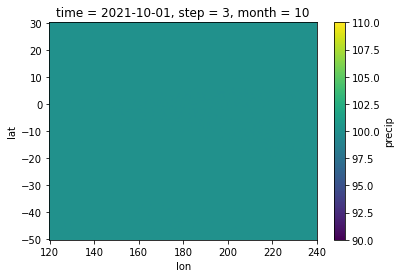

In [29]:
probs.sum(quantile).squeeze().sel(step=3)['precip'].plot()

In [30]:
probs

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 5, lat: 324, lon: 484)
Coordinates:
  * time     (time) datetime64[ns] 2021-10-01
  * step     (step) int64 1 2 3 4 5
    month    int64 10
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.5 120.7 ... 239.3 239.5 239.8 240.0
  * lat      (lat) float64 -50.0 -49.75 -49.5 -49.26 ... 29.26 29.5 29.75 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 324, 484), meta=np.ndarray>

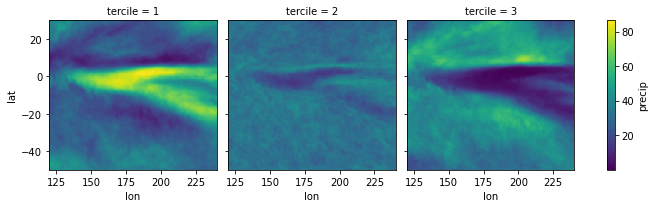

In [31]:
probs.sel(step=3).squeeze()['precip'].plot(col=quantile)

### EEZ shapes 

In [32]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [33]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

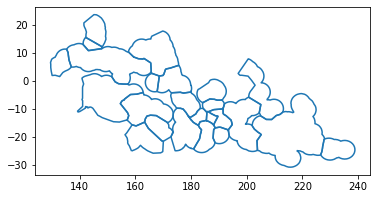

In [34]:
EEZs.boundary.plot(); 

In [35]:
probs

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 5, lat: 324, lon: 484)
Coordinates:
  * time     (time) datetime64[ns] 2021-10-01
  * step     (step) int64 1 2 3 4 5
    month    int64 10
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.5 120.7 ... 239.3 239.5 239.8 240.0
  * lat      (lat) float64 -50.0 -49.75 -49.5 -49.26 ... 29.26 29.5 29.75 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 324, 484), meta=np.ndarray>

In [36]:
probs = geo.make_mask_from_gpd(probs, merged_EEZs, subset=False, mask_name='mask')

In [37]:
probs

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 5, lat: 324, lon: 484)
Coordinates:
  * time     (time) datetime64[ns] 2021-10-01
  * step     (step) int64 1 2 3 4 5
    month    int64 10
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.5 120.7 ... 239.3 239.5 239.8 240.0
  * lat      (lat) float64 -50.0 -49.75 -49.5 -49.26 ... 29.26 29.5 29.75 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 324, 484), meta=np.ndarray>
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [38]:
thresholds = [0, 10, 20, 40, 50, 60, 70, 100.0]

In [39]:
hexes = ['#1549b0','#62a3bf','#ffffff','#f5e464','#e39f39','#ff1212','#7d0f05']

In [40]:
import matplotlib

In [41]:
cmap = matplotlib.colors.ListedColormap(hexes, name='probabilities')

### parametrized terciles climatological values 

In [42]:
from matplotlib import pyplot as plt 
from cartopy import crs as ccrs

In [43]:
from calendar import month_name

In [44]:
month_name = list(month_name) + list(month_name)[1:]

### choose the step for the forecast here 

In [86]:
period

'monthly'

In [147]:
step = 5

In [148]:
if period == 'monthly': 
    label_period = month_name[month + step]
elif period == 'seasonal': 
    label_period = month_name[month + step - 2] + " - " + month_name[month + step]

In [149]:
month

10

In [150]:
label_period.replace(" - ","_")

'March'

In [151]:
dset = probs['precip'] * probs['mask']

In [152]:
dset = dset.to_dataset(name='precip')

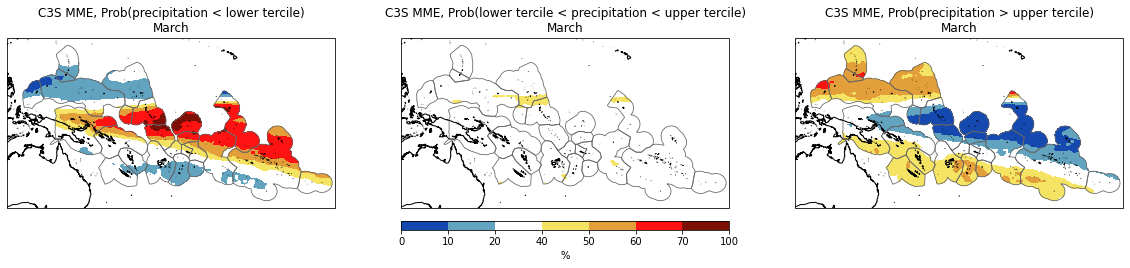

In [153]:
f, axes = plt.subplots(ncols=3, figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ax = axes[0]
ax.coastlines(resolution='10m')
im1 = dset['precip'].sel(step=step, tercile=1).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title(f"C3S MME, Prob(precipitation < lower tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

ax = axes[1]
ax.coastlines(resolution='10m')
im2 = dset['precip'].sel(step=step, tercile=2).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title(f"C3S MME, Prob(lower tercile < precipitation < upper tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

cbar_ax = ax.axes.inset_axes([0, -0.125, 1, 0.05])

cb = plt.colorbar(im2, cax=cbar_ax, orientation='horizontal')

cb.set_label("%")

ax = axes[2]
ax.coastlines(resolution='10m')
im3 = dset['precip'].sel(step=step, tercile=3).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False, title='')
ax.set_title(f"C3S MME, Prob(precipitation > upper tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

f.savefig(f'/home/nicolasf/Desktop/C3S_ECMWF_{period}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png', dpi=200, bbox_inches='tight', facecolor='w')


In [154]:
dset

<xarray.Dataset>
Dimensions:  (time: 1, step: 5, tercile: 3, lon: 484, lat: 324)
Coordinates:
  * time     (time) datetime64[ns] 2021-10-01
  * step     (step) int64 1 2 3 4 5
    month    int64 10
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.5 120.7 ... 239.3 239.5 239.8 240.0
  * lat      (lat) float64 -50.0 -49.75 -49.5 -49.26 ... 29.26 29.5 29.75 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 324, 484), meta=np.ndarray>

In [155]:
probs

<xarray.Dataset>
Dimensions:   (tercile: 3, time: 1, step: 5, lat: 324, lon: 484)
Coordinates:
  * time      (time) datetime64[ns] 2021-10-01
  * step      (step) int64 1 2 3 4 5
    month     int64 10
  * tercile   (tercile) int64 1 2 3
  * lon       (lon) float64 120.0 120.2 120.5 120.7 ... 239.3 239.5 239.8 240.0
  * lat       (lat) float64 -50.0 -49.75 -49.5 -49.26 ... 29.26 29.5 29.75 30.0
Data variables:
    precip    (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 324, 484), meta=np.ndarray>
    mask      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    category  (step, lat, lon) float64 dask.array<chunksize=(5, 324, 484), meta=np.ndarray>

In [156]:
probs_t = probs[['precip']]

In [157]:
probs_t = probs_t.idxmax(dim='tercile')

In [158]:
probs_t = probs_t.squeeze()

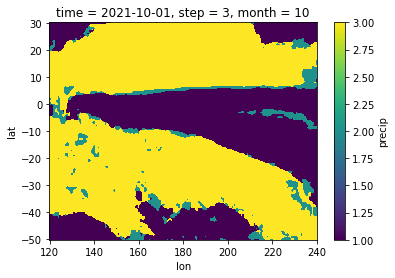

In [159]:
probs_t.sel(step=3)['precip'].plot()

In [160]:
probs['category'] = probs_t['precip']

In [161]:
probs

<xarray.Dataset>
Dimensions:   (tercile: 3, time: 1, step: 5, lat: 324, lon: 484)
Coordinates:
  * time      (time) datetime64[ns] 2021-10-01
  * step      (step) int64 1 2 3 4 5
    month     int64 10
  * tercile   (tercile) int64 1 2 3
  * lon       (lon) float64 120.0 120.2 120.5 120.7 ... 239.3 239.5 239.8 240.0
  * lat       (lat) float64 -50.0 -49.75 -49.5 -49.26 ... 29.26 29.5 29.75 30.0
Data variables:
    precip    (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 324, 484), meta=np.ndarray>
    mask      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    category  (step, lat, lon) float64 dask.array<chunksize=(5, 324, 484), meta=np.ndarray>

In [172]:
cmap_1 = plt.cm.Oranges

In [173]:
cmap_2 = plt.cm.gray_r

In [174]:
cmap_3 = plt.cm.Greens

In [175]:
ticks = np.arange(40,110,10)

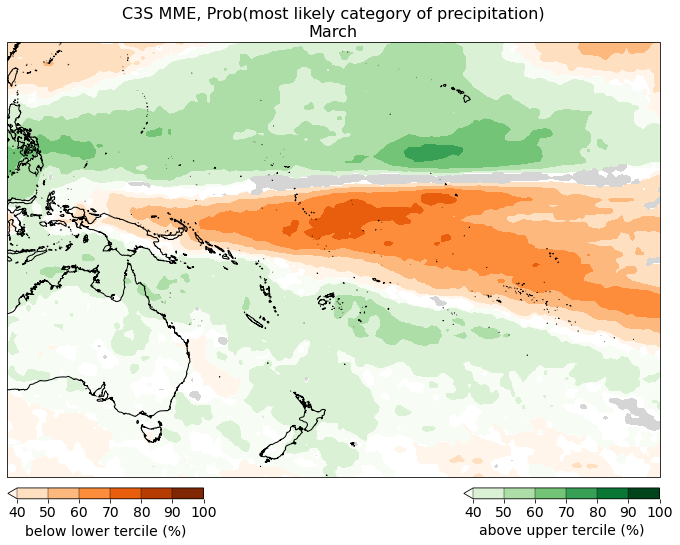

In [176]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))

im1 = probs.where(probs['category'] == 1).squeeze().sel(tercile=1,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_1, add_colorbar=False, transform=ccrs.PlateCarree())

# cbar_ax_1 = ax.axes.inset_axes([1.01, 0.7, 0.025, 0.2])

cbar_ax_1 = ax.axes.inset_axes([0.001, -0.05, 0.3, 0.025])

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'both', 'drawedges':True, 'ticks':np.arange(40,110,10), 'aspect':15, 'orientation':'horizontal'}

cb1 = plt.colorbar(im1, cax=cbar_ax_1, **cbar_kwargs)

cb1.set_ticklabels(ticks)

cb1.ax.tick_params(labelsize=14)

cb1.set_label("below lower tercile (%)", fontsize=14)

im2 = probs.where(probs['category'] == 2).squeeze().sel(tercile=2, step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_2, add_colorbar=False, transform=ccrs.PlateCarree())

im3 = probs.where(probs['category'] == 3).squeeze().sel(tercile=3,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_3, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_3 = ax.axes.inset_axes([0.7, -0.05, 0.3, 0.025], )

cb3 = plt.colorbar(im3, cax=cbar_ax_3, **cbar_kwargs)

cb3.set_ticklabels(ticks)

cb3.ax.tick_params(labelsize=14)

cb3.set_label("above upper tercile (%)", fontsize=14)

ax.coastlines(resolution='10m')

ax.set_title(f"C3S MME, Prob(most likely category of precipitation)\n{label_period}", fontsize=16)

f.savefig(f'/home/nicolasf/Desktop/C3S_most_likely_category_{period}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png', dpi=200, bbox_inches='tight', facecolor='w')
